In [53]:
# Скачиваем PDF (восстановил ячейку)
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

base_url = "https://farmaciajournal.com/article-archive/"

# Папка для сохранения файлов
root_folder = "/Volumes/Macintosh HD/Users/alexmatyushin/projectterm"

try:
    response = requests.get(base_url)
    response.raise_for_status()
except requests.RequestException as e:
    print(f"Ошибка при загрузке архива статей: {e}")
    exit(1)

soup = BeautifulSoup(response.text, "html.parser")

# Ищем все ссылки на выпуски журнала
article_links = soup.find_all("a", class_="ArticleLink")

# Перебираем ссылки на выпуски журнала
for link in article_links:
    issue_url = link.get("href")
    issue_name = link.get_text().strip().replace("/", "_")  # Для названий папок
    issue_folder = os.path.join(root_folder, issue_name)

    # Создаем подпапку для выпуска, если её нет
    if not os.path.exists(issue_folder):
        os.makedirs(issue_folder)

    print(f"Обрабатывается выпуск: {issue_name}")

    # Отправляем запрос на страницу выпуска
    try:
        issue_response = requests.get(issue_url)
        issue_response.raise_for_status()
    except requests.RequestException as e:
        print(f"Ошибка при загрузке страницы выпуска {issue_url}: {e}")
        continue  # Следующий выпуск

    issue_soup = BeautifulSoup(issue_response.text, "html.parser")

    # Ищем все ссылки на PDF-файлы
    pdf_links = issue_soup.find_all("a", href=True)

    for pdf_link in pdf_links:
        pdf_url = pdf_link["href"]
        
        # Точно PDF?
        if not pdf_url.endswith(".pdf"):
            continue
        
        pdf_name = pdf_url.split("/")[-1]
        pdf_path = os.path.join(issue_folder, pdf_name)

        # Чтобы бесконечно не скачивать одно и то же
        if os.path.exists(pdf_path):
            print(f"Файл уже существует: {pdf_path}.")
            continue

        try:
            print(f"Загружаем: {pdf_url}")
            pdf_response = requests.get(pdf_url, stream=True)
            pdf_response.raise_for_status()

            # Сохраняем файл
            with open(pdf_path, "wb") as pdf_file:
                for chunk in pdf_response.iter_content(chunk_size=1024):
                    pdf_file.write(chunk)

            print(f"Файл сохранен: {pdf_path}")

        except requests.HTTPError as http_err:
            print(f"Ошибка HTTP ({http_err.response.status_code}) при загрузке {pdf_url}: {http_err}")
        except requests.RequestException as req_err:
            print(f"Ошибка запроса при загрузке {pdf_url}: {req_err}")
        except Exception as e:
            print(f"Неизвестная ошибка при обработке {pdf_url}: {e}")

print("Done")

Обрабатывается выпуск: Farmacia Journal 6_2024
Файл уже существует: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 6_2024/Farmacia-nr6-2024-coperta-1-4-web.pdf.
Файл уже существует: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 6_2024/art-01-Ganesh_Satchanska_1227-1236_1.pdf.
Файл уже существует: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 6_2024/art-02-Jan_Alkharfy_Mirza_1237-1250.pdf.
Файл уже существует: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 6_2024/art-03-Potpara_Medarevic_Ibric_1251-1260_1.pdf.
Файл уже существует: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 6_2024/art-04-Ruse_Cheveresan_Heghes_1261-1272.pdf.
Файл уже существует: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 6_2024/art-05-Adam-Dima_OLteanu_Purdel_1273-1282.pdf.
Файл уже существует: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 6_202

In [1]:
# Извлекаем текст из всех PDF
import os
import re
import PyPDF2

# Папка для PDF
root_folder = "/Volumes/Macintosh HD/Users/alexmatyushin/projectterm"

# Перебираем все папки в корневом каталоге
for issue_name in os.listdir(root_folder):
    issue_folder = os.path.join(root_folder, issue_name)
    # Пропускаем файлы, берем только папки
    if not os.path.isdir(issue_folder):
        continue

    print(f"Обрабатывается выпуск: {issue_name}")

    # Перебираем все файлы в папке выпуска
    for file_name in os.listdir(issue_folder):
        if not file_name.endswith(".pdf"):
            continue  # Пропускаем любые другие файлы

        pdf_path = os.path.join(issue_folder, file_name)
        txt_path = os.path.join(issue_folder, file_name.replace(".pdf", ".txt"))

        # Проверяем, вдруг уже обработали?
        if os.path.exists(txt_path):
            print(f"Файл {txt_path} уже существует, пропускаем.")
            continue

        print(f"Извлекаем текст из: {pdf_path}")

        # Открываем PDF-файл
        try:
            with open(pdf_path, "rb") as pdf_file:
                reader = PyPDF2.PdfReader(pdf_file)
                text = ""

                # Перебираем страницы и извлекаем текст
                for page in reader.pages:
                    text += page.extract_text() + "\n"

        except Exception as e:
            print(f"Ошибка при обработке {pdf_path}: {e}")
            continue

        # Удаляем текст между "Rezumat" и "Keywords" (там румынская аннотация)
        processed_text = re.sub(r"Rezumat.*?Keywords", "Keywords", text, flags=re.DOTALL)

        # Сохраняем обработанный текст в файл
        try:
            with open(txt_path, "w", encoding="utf-8") as txt_file:
                txt_file.write(processed_text)

            print(f"Файл сохранен: {txt_path}")

        except Exception as e:
            print(f"Ошибка при сохранении {txt_path}: {e}")

print("Извлечение и обработка текста - done.")

Обрабатывается выпуск: Farmacia Journal 3_2019
Файл /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 3_2019/2019-03-art-18-Ciulu_Constantinescu_Podgorenu_Chifiriuc_496-503.txt уже существует, пропускаем.
Файл /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 3_2019/2019-03-coverwebSM.txt уже существует, пропускаем.
Файл /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 3_2019/2019-03-art-20-Becheanu_Tincu_Pacurar_511-516.txt уже существует, пропускаем.
Файл /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 3_2019/2019-03-art-14-Mazilu_Stoian_Suceveanu_472-476.txt уже существует, пропускаем.
Файл /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 3_2019/2019-03-art-05-Teaha_Lazar_411-417.txt уже существует, пропускаем.
Файл /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 3_2019/2019-03-art-15-Purza_Iovan_Tit_477-481.txt уже существует, пропускаем.
Файл /Volumes

In [15]:
# Объединяем текст во всех выпусках
# Перебираем все папки (= выпуски)
for issue_name in os.listdir(root_folder):
    issue_folder = os.path.join(root_folder, issue_name)

    # Пропускаем, если это не папка
    if not os.path.isdir(issue_folder):
        continue

    print(f"Обрабатывается выпуск: {issue_name}")

    combined_text = ""  # Переменная для объединенного текста

    # Перебираем все файлы в папке выпуска
    for file_name in sorted(os.listdir(issue_folder)):  # Сортируем для упорядоченности
        if not file_name.endswith(".txt"):
            continue  # Пропускаем нетекстовые файлы

        txt_path = os.path.join(issue_folder, file_name)

        print(f"Добавляем в общий файл: {txt_path}")

        # Читаем содержимое текстового файла
        try:
            with open(txt_path, "r", encoding="utf-8") as txt_file:
                combined_text += txt_file.read() + "\n\n"
        except Exception as e:
            print(f"Ошибка при чтении {txt_path}: {e}")

    # Создаем объединенный текстовый файл в папке с проектом
    combined_txt_path = os.path.join(root_folder, f"{issue_name}.txt")

    try:
        with open(combined_txt_path, "w", encoding="utf-8") as combined_txt_file:
            combined_txt_file.write(combined_text)
        print(f"Объединенный файл сохранен: {combined_txt_path}")
    except Exception as e:
        print(f"Ошибка при сохранении {combined_txt_path}: {e}")

print("Объединение текстов - done.")

Обрабатывается выпуск: Farmacia Journal 3_2019
Добавляем в общий файл: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 3_2019/2019-03-art-00-Prima_pagina_2019.03.txt
Добавляем в общий файл: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 3_2019/2019-03-art-01-Negru_Tiliscan_Arama_383-391.txt
Добавляем в общий файл: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 3_2019/2019-03-art-02-Codea_Mircean_Liviu_392-397.txt
Добавляем в общий файл: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 3_2019/2019-03-art-03-Mititelu_Ionita_Morosan_398-404.txt
Добавляем в общий файл: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 3_2019/2019-03-art-04-Burlec_Cioanca_Hancianu_405-410.txt
Добавляем в общий файл: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 3_2019/2019-03-art-05-Teaha_Lazar_411-417.txt
Добавляем в общий файл: /Volumes/Macintosh HD/Users/alexmatyushin

In [17]:
# Сохраняем все тексты выпусков за каждый год в один файл
from collections import defaultdict

# Папка с объединенными файлами выпусков
root_folder = "/Volumes/Macintosh HD/Users/alexmatyushin/projectterm"

# Создаем словарь для хранения текстов по годам
yearly_texts = defaultdict(str)

# Перебираем все файлы в корневой папке
for file_name in sorted(os.listdir(root_folder)):  # Сортируем для порядка
    if not file_name.endswith(".txt"):
        continue  # Пропускаем не текстовые файлы

    # Ищем год в названии файла (формат файла у нас вот такой: "Farmacia Journal 2_2012.txt")
    match = re.search(r"(\d{4})", file_name)
    if not match:
        print(f"Не удалось определить год для файла: {file_name}, пропускаем.")
        continue

    year = match.group(1)  # Извлекаем год

    txt_path = os.path.join(root_folder, file_name)
    print(f"Добавляем в общий файл за {year}: {txt_path}")

    # Читаем содержимое текстового файла и добавляем его к тексту соответствующего года
    try:
        with open(txt_path, "r", encoding="utf-8") as txt_file:
            yearly_texts[year] += txt_file.read() + "\n\n"
    except Exception as e:
        print(f"Ошибка при чтении {txt_path}: {e}")

# Создаем объединенные файлы по годам
for year, combined_text in yearly_texts.items():
    combined_txt_path = os.path.join(root_folder, f"{year}.txt")

    try:
        with open(combined_txt_path, "w", encoding="utf-8") as combined_txt_file:
            combined_txt_file.write(combined_text)
        print(f"Объединенный файл за {year} сохранен: {combined_txt_path}")
    except Exception as e:
        print(f"Ошибка при сохранении {combined_txt_path}: {e}")

print("Объединение текстов по годам - done.")

Добавляем в общий файл за 2012: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 1_2012.txt
Добавляем в общий файл за 2013: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 1_2013.txt
Добавляем в общий файл за 2014: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 1_2014.txt
Добавляем в общий файл за 2015: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 1_2015.txt
Добавляем в общий файл за 2016: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 1_2016.txt
Добавляем в общий файл за 2017: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 1_2017.txt
Добавляем в общий файл за 2018: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 1_2018.txt
Добавляем в общий файл за 2019: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Farmacia Journal 1_2019.txt
Добавляем в общий файл за 2020: /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/Fa

In [19]:
# Объединяем все в один корпус

root_folder = "/Volumes/Macintosh HD/Users/alexmatyushin/projectterm"
output_file = os.path.join(root_folder, "all_years.txt")

# Список файлов с текстами по годам
year_files = sorted([f for f in os.listdir(root_folder) if f.endswith(".txt") and f[:-4].isdigit()])

# Объединяем тексты всех файлов
combined_text = ""

for year_file in year_files:
    file_path = os.path.join(root_folder, year_file)
    
    print(f"Добавляем содержимое {file_path}")

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            combined_text += f.read() + "\n\n"  # Добавляем двойной перенос строки между текстами
    except Exception as e:
        print(f"Ошибка при чтении {file_path}: {e}")

# Записываем объединенный текст в общий файл
try:
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(combined_text)
    print(f"Общий файл сохранен: {output_file}")
except Exception as e:
    print(f"Ошибка при сохранении {output_file}: {e}")

print("Объединение всех текстов - done.")


Добавляем содержимое /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/2012.txt
Добавляем содержимое /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/2013.txt
Добавляем содержимое /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/2014.txt
Добавляем содержимое /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/2015.txt
Добавляем содержимое /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/2016.txt
Добавляем содержимое /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/2017.txt
Добавляем содержимое /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/2018.txt
Добавляем содержимое /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/2019.txt
Добавляем содержимое /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/2020.txt
Добавляем содержимое /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/2021.txt
Добавляем содержимое /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/2022.txt
Добавляем содержимое /Volumes/Macintosh HD/Users/alexmatyushin/projectterm/2

In [21]:
# Посмотрим, выводится ли?
path = '/Volumes/Macintosh HD/Users/alexmatyushin/projectterm/all_years.txt'
with open(path, encoding='utf-8') as txt:
    text = txt.read()
    
# Приведем к нижнему регистру
text = text.lower()
print(text[:1000])

farmacia, 2012, vol. 60, 1 
 1 new modified electrodes with hrp immobilized in polymeric films for paracetamol analysis  andreea cernat1*, mihaela tertis2, sophie griveau3, fethi bedioui3,  robert sandulescu1 1"iuliu haţieganu" university of medicine and pharmacy, faculty of pharmacy, analytical chemistry dept., 4 pasteur st. 400349, cluj-napoca, romania,  2“babes-bolyai” university, faculty of chemistry and chemical engineering, 11 arany janos st. 400028, cluj-napoca, romania 3unité pharmacologie chimique et génétique et imagerie, cnrs 8151/inserm u 1022/université paris descartes/chimie paristech, 11 rue pierre et marie curie, 75231 paris cedex 05, france *corresponding author : ilioaia.andreea@umfcluj.ro  abstract in order to establish the configurations of biosensors that are able to detect paracetamol in various matrices, it was studied the behaviour of some modified electrodes with an electroconductive polymeric film. polypyrrole films deposition on glassy carbon and screen-print

In [23]:
# препроцессинг
import re

# Удаляем фрагменты вида "farmacia, 2012, vol. 60, 1"
clean_text = re.sub(r"farmacia,\s*\d{4},\s*vol\.\s*\d+,\s*\d+", "", text)

# Удаление всех чисел
clean_text = re.sub(r"\d+", "", clean_text)

# Удаление слов, содержащих нелатинские символы
clean_text = re.sub(r"\b[^\x00-\x7F]+\b", "", clean_text)

# Удаление email-адресов
clean_text = re.sub(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", "", clean_text)

# Удаление слов, содержащих символы ţăâé (проскочили на предыдущем этапе)
clean_text = re.sub(r"\b\w*[ţăâé]\w*\b", "", clean_text, flags=re.IGNORECASE)

# Убираем ФИО румын
suffixes = r"(escu|eanu|an|aru|ăscu|oiu|enco|ilescu|ache|ulescu|ică)"  # Добавьте другие суффиксы при необходимости
clean_text = re.sub(r"\b\w*" + suffixes + r"\b", "", clean_text, flags=re.IGNORECASE)

# Удаляем лишние пробелы и переносы строк
clean_text = re.sub(r"\s+", " ", clean_text).strip()

# Удаляем слова, содержащие "/"
clean_text = re.sub(r"\b\w*/\w*\b", "", clean_text)

# Удаляем слова из двух букв
clean_text = re.sub(r"\b\w{2}\b", "", clean_text)

# Удаляем фрагменты вида "table ii", "table iii" и т.п.
clean_text = re.sub(r"\btable\s+[ivxlcdm]+\b", "", clean_text, flags=re.IGNORECASE)

# Удаляем все знаки препинания
clean_text = re.sub(r"[^\w\s]", "", clean_text)

# Удаляем слова (приходится пополнять список)
unwanted_words = {"doi", "org", "author", "manuscript", "article", "figure", "romania", "bucharest",
                  "university", "farmacia", "date", "time", "med", "chem", "authors", "pharm", "sci",
                 "ageu", "levai", "aio", "krk", "aleconsiliului", "stiintific", "amoutzias", "matakos",
                  "augustynowiczkopec", "napiorkowska", "avco", "bsucrose", "beitr", "tabakforsch",
                  "bergmeister", "podesser", "bigovic", "roganovic", "blankfassif", "peakfassif",
                  "boberg", "taxvig", "bonacucina", "cespi", "boshy", "risha"
                  "blankfessif", "peakfessif", "acordarea"              }
words = clean_text.split()  # Разбиваем текст на слова
filtered_words = [word for word in words if word.lower() not in unwanted_words]  # Фильтруем список

# Собираем обратно
clean_text = " ".join(filtered_words)

# УДАЛЯЕМ СТОП-СЛОВА (внешний большой список)
# Путь к файлу со стоп-словами
stopwords_path = "/Volumes/Macintosh HD/Users/alexmatyushin/projectterm/alir3z4.txt"

# Загружаем стоп-слова из файла
with open(stopwords_path, "r", encoding="utf-8") as f:
    stopwords = set(f.read().splitlines())  # Стоп-слова -> в множество

# NB! Переписать потом: код избыточен, разбиваем же уже выше
# Разбиваем текст на слова, удаляя стоп-слова
words = clean_text.split()  # Разбиваем текст на отдельные слова
filtered_words = [word for word in words if word.lower() not in stopwords]  # Фильтруем стоп-слова

# Собираем текст обратно
clean_text = " ".join(filtered_words)
# Отображается?
print(clean_text[:1000])

modified electrodes hrp immobilized polymeric films paracetamol analysis andreea cernat mihaela tertis sophie griveau fethi bedioui robert iuliu medicine pharmacy faculty pharmacy analytical chemistry dept pasteur clujnapoca babesbolyai faculty chemistry chemical engineering arany janos clujnapoca pharmacologie chimique imagerie cnrs inserm paris paristech rue pierre marie curie paris cedex france abstract establish configurations biosensors detect paracetamol matrices studied behaviour modified electrodes electroconductive polymeric film polypyrrole films deposition glassy carbon screenprinted electrodes developped methods electroanalytical characterization deposited films performed chronoamperometry presence enzyme immobilized polymeric films chronoamperometric study performed glassy carbon planar electrodes based graphite modified horseradish peroxidase embedded polypyrrole films proved existence interactions immobilized enzyme electroactive species paracetamol nacetylpbenzoquinone 

In [25]:
# Извлекаем топ-30 биграмм по PMI (Pointwise Mutual Information)
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.tokenize import word_tokenize

# nltk.download("punkt")

# Токенизация текста
tokens = word_tokenize(clean_text)  # Используем уже очищенный текст

# Инициализация объекта для поиска биграмм
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(tokens)

# NB! Повысить порог? Иначе не очень полезная метрика
# Оставляем только биграммы, встречающиеся не менее 3 раз
finder.apply_freq_filter(3)

top_bigrams = finder.nbest(bigram_measures.pmi, 30)

for bigram in top_bigrams:
    print(" ".join(bigram))

acetylsalicilic acidacetaminophen
allopurinolxanthine oxidaselucigenin
annulen acetylhydrazones
antiintestinal nematode
aparisthmium cordatum
arched recurved
arctostaphylos uvaursi
argic cambic
arylparachlorophenylsulfonylphenyl methyloxazoles
astra zeneca
aurobasidium pullulans
bacoside bacopaside
baumgartenii simonk
bryophyllum pinnatum
bures leobandung
bursulaya totrov
buthionine sulfoximine
bwam bwmetamizole
cassioides rottl
centrif uged
chaita panagoulis
chateauvieux morceau
choles terol
clams oysters
coccinia grandis
comptes rendus
concl usions
coreana uyeki
corylopsis coreana
corym bosum


In [27]:
# Попытка проверить, не является ли у нас биграмма одним словом 

# nltk.download('words')
from nltk.corpus import words
from difflib import SequenceMatcher

def is_split_word(bigram):
    word_list = set(words.words())  # Грузим список слов из корпуса
    combined_word = ''.join(bigram)  # Объединяем слова в биграмме
    if combined_word.lower() in word_list: # Проверяем наличие в корпусе
        return True
    # Используем SequenceMatcher для проверки схожести слов
    for word in word_list:
        similarity = SequenceMatcher(None, combined_word.lower(), word.lower()).ratio()
        if similarity > 0.9:  # Порог схожести
            return True
    return False

for bigram in top_bigrams:
    if is_split_word(bigram):
        print(f"{bigram}: вероятно одно слово")

('centrif', 'uged'): вероятно одно слово
('choles', 'terol'): вероятно одно слово
('concl', 'usions'): вероятно одно слово


In [29]:
# Биграммы методом TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Создаем векторизатор с биграммами
vectorizer = TfidfVectorizer(ngram_range=(2, 2), max_features=50)  # max_features = топ-50 биграмм

# Преобразуем текст в матрицу TF-IDF
tfidf_matrix = vectorizer.fit_transform([clean_text])

# Получаем биграммы и величины TF-IDF 
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()[0]

# Сортируем биграммы по величине TF-IDF
sorted_bigrams = sorted(zip(feature_names, tfidf_scores), key=lambda x: x[1], reverse=True)

max_score = max(score for _, score in sorted_bigrams[:30])
# Выводим топ-30 биграмм с наибольшими значениями TF-IDF
for bigram, score in sorted_bigrams[:30]:
    percentage = (score / max_score) * 100
    print(f"{bigram}: {score:.4f} ({percentage:.2f}%)")

medicine pharmacy: 0.4117 (100.00%)
antioxidant activity: 0.2882 (69.99%)
oxidative stress: 0.2678 (65.04%)
faculty pharmacy: 0.2189 (53.15%)
materials methods: 0.2129 (51.71%)
essential oil: 0.2078 (50.48%)
antimicrobial activity: 0.1898 (46.11%)
carol davila: 0.1713 (41.61%)
drug release: 0.1592 (38.66%)
drug delivery: 0.1488 (36.13%)
anti inflammatory: 0.1475 (35.83%)
statistical analysis: 0.1474 (35.80%)
compared control: 0.1412 (34.29%)
standard deviation: 0.1256 (30.50%)
davila medicine: 0.1211 (29.42%)
diabetes mellitus: 0.1208 (29.33%)
blood pressure: 0.1161 (28.19%)
essential oils: 0.1146 (27.82%)
type diabetes: 0.1143 (27.76%)
risk factors: 0.1137 (27.61%)
antioxidant capacity: 0.1127 (27.36%)
staphylococcus aureus: 0.1105 (26.84%)
antibacterial activity: 0.1068 (25.95%)
particle size: 0.1052 (25.55%)
cell lines: 0.1049 (25.48%)
breast cancer: 0.1026 (24.93%)
systematic review: 0.0991 (24.07%)
distilled water: 0.0988 (24.01%)
declare conflict: 0.0969 (23.55%)
conflict referen

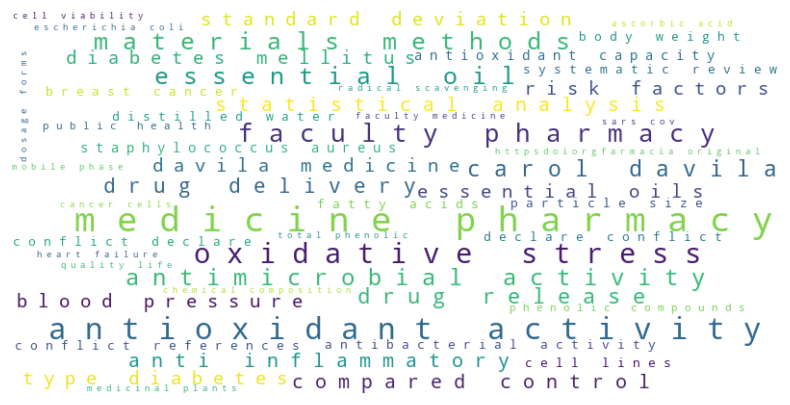

In [31]:
# Пробуем визуализировать 
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def visualize_bigrams(sorted_bigrams):
    # Преобразуем биграммы в строку с повторениями по весу TF-IDF
    bigram_dict = {" ".join(bigram): weight for bigram, weight in sorted_bigrams}
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
    wordcloud.generate_from_frequencies(bigram_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
visualize_bigrams(sorted_bigrams)

In [42]:
# Столбчатая диаграмма (сохраняем для презентации)
import numpy as np

def visualize_bigrams_bar(sorted_bigrams, filename='bigrams_chart.png'):
    bigrams = [" ".join(bigram) for bigram, _ in sorted_bigrams]
    weights = [weight for _, weight in sorted_bigrams]
    
    # Создание столбчатой диаграммы
    plt.figure(figsize=(10, 6))
    x_pos = np.arange(len(bigrams))
    plt.bar(x_pos, weights, color='skyblue')
    plt.xticks(x_pos, bigrams, rotation=45, ha='right')
    plt.ylabel('величинаTF-IDF')
    plt.xlabel('Биграммы')
    plt.title('Визуализация биграмм')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

visualize_bigrams_bar(sorted_bigrams, 'bigrams.png')

In [9]:
# RAKE не работает, пробуем YAKE
# !pip install yake

In [33]:
import yake

language = "en"
max_ngram_size = 2  # Биграммы
deduplication_threshold = 0.9  # Порог для удаления дубликатов
num_keywords = 30  # Количество извлекаемых терминов

yake_extractor = yake.KeywordExtractor(
    lan=language,
    n=max_ngram_size,
    dedupLim=deduplication_threshold,
    top=num_keywords
)

# Извлекаем термины
yake_keywords = yake_extractor.extract_keywords(clean_text)

# Определяем максимальное значение TF-IDF в топ-30
max_score = max(score for _, score in yake_keywords[:30])

for keyword, score in yake_keywords[:30]:
    percentage = (score / max_score) * 100  # Вычисляем процент
    # значения Score очень маленькие, не сокращаем вывод
    print(f"{keyword} (Score: {score}, {percentage:.2f}%)")

medicine pharmacy (Score: 2.9851717779933794e-09, 10.17%)
antioxidant activity (Score: 2.9896228229236976e-09, 10.18%)
drug release (Score: 5.376284888033071e-09, 18.32%)
patients patients (Score: 6.649777722339164e-09, 22.65%)
antimicrobial activity (Score: 7.511356049962534e-09, 25.59%)
materials methods (Score: 7.79912217106303e-09, 26.57%)
study patients (Score: 8.231314301842694e-09, 28.04%)
treatment patients (Score: 8.323642860492124e-09, 28.36%)
compared control (Score: 1.0025470637112457e-08, 34.15%)
cancer cells (Score: 1.0365855906344146e-08, 35.31%)
faculty pharmacy (Score: 1.1681880915432408e-08, 39.80%)
patients study (Score: 1.455446028825822e-08, 49.58%)
drug delivery (Score: 1.4680435570701942e-08, 50.01%)
patients treated (Score: 1.5576009357161613e-08, 53.06%)
statistical analysis (Score: 1.6635529404026288e-08, 56.67%)
essential oil (Score: 1.7099473408410966e-08, 58.25%)
patients treatment (Score: 1.804182274473162e-08, 61.46%)
risk factors (Score: 1.99414044722327

In [37]:
# Сопоставляем результаты TF-IDF и YAKE
# Преобразуем биграммы из TF-IDF в множество (разделяем на слова)
tfidf_bigrams_set = {"".join(bigram) for bigram, _ in sorted_bigrams}
# print(tfidf_bigrams_set)

yake_terms_set = {term.lower() for term, _ in yake_keywords}
# print(yake_terms_set)
    
# Находим пересечение (совпадающие термины)
common_terms = tfidf_bigrams_set & yake_terms_set

# Выводим совпадающие термины
print("Совпадающие термины:")
for term in common_terms:
    print(term)

Совпадающие термины:
risk factors
materials methods
drug delivery
statistical analysis
cancer cells
antimicrobial activity
compared control
antibacterial activity
essential oil
antioxidant activity
medicine pharmacy
oxidative stress
phenolic compounds
faculty pharmacy
drug release


In [39]:
# Посмотрим просто частоту слов по корпусу
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

# Токенизация текста на слова
tokens = word_tokenize(clean_text)

# Длина тексте
total_words = len(tokens)
print(f"Всего {total_words} слов в корпусе")

# Подсчет частоты слов
freq_dist = FreqDist(tokens)

# Получение топ-30 наиболее частотных слов
top_30_words = freq_dist.most_common(30)

# Вывод результатов
print("Топ-30:")
for word, freq in top_30_words:
    percentage = (freq / total_words) * 100
    print(f"{word}: {freq} ({percentage:.2f}%)")


Всего 3629740 слов в корпусе
Топ-30:
patients: 22446 (0.62%)
study: 18297 (0.50%)
treatment: 15179 (0.42%)
activity: 14538 (0.40%)
drug: 13569 (0.37%)
acid: 12590 (0.35%)
cells: 10983 (0.30%)
analysis: 10382 (0.29%)
effects: 10040 (0.28%)
control: 8964 (0.25%)
compounds: 8837 (0.24%)
extract: 8822 (0.24%)
cell: 8754 (0.24%)
studies: 8319 (0.23%)
pharmacy: 8216 (0.23%)
concentration: 7874 (0.22%)
data: 7864 (0.22%)
method: 7770 (0.21%)
antioxidant: 7623 (0.21%)
compared: 7617 (0.21%)
release: 6935 (0.19%)
clinical: 6901 (0.19%)
values: 6815 (0.19%)
levels: 6696 (0.18%)
drugs: 6626 (0.18%)
health: 6536 (0.18%)
medicine: 6366 (0.18%)
total: 6342 (0.17%)
cancer: 6317 (0.17%)
extracts: 6167 (0.17%)


In [41]:
# Визуализируем и сохраняем в файл
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def visualize_top_words_wordcloud(top_30_words, filename='wordcloud.png'):
    # Преобразуем список в словарь
    word_freq_dict = {word: freq for word, freq in top_30_words}
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
    wordcloud.generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

visualize_top_words_wordcloud(top_30_words, 'wordcloud.png')

In [43]:
# Пробуем показать потенциальные коллокации

import nltk
from collections import Counter
from nltk.tokenize import word_tokenize

# Токенизация текста
tokens = word_tokenize(clean_text)

# Подсчет частоты слов
freq_dist = nltk.FreqDist(tokens)

# Получаем топ-30 самых частых слов
top_30_words = [word for word, _ in freq_dist.most_common(30)]

# Словари для хранения частот словосочетаний
previous_words_counter = {word: Counter() for word in top_30_words}
next_words_counter = {word: Counter() for word in top_30_words}

# Проход по тексту и сбор соседних слов
for i in range(1, len(tokens) - 1):
    word = tokens[i]
    if word in top_30_words:
        previous_word = tokens[i - 1]  # Слово до
        next_word = tokens[i + 1]  # Слово после

        # Записываем биграммы
        previous_words_counter[word][f"{previous_word} {word}"] += 1
        next_words_counter[word][f"{word} {next_word}"] += 1

print("ТОП-30 кандидатов в коллокации для каждого термина из ТОП-30:")
for word in top_30_words:
    print(f"Термин: {word}")

    # Топ-30 предшествующих словосочетаний
    print("Коллокации 'слева'")
    for phrase, count in previous_words_counter[word].most_common(30):
        print(f"    {phrase}: {count}")

    # Топ-30 последующих словосочетаний
    print("Коллокации 'справа'")
    for phrase, count in next_words_counter[word].most_common(30):
        print(f"    {phrase}: {count}")

ТОП-30 кандидатов в коллокации для каждого термина из ТОП-30:
Термин: patients
Коллокации 'слева'
    treatment patients: 414
    study patients: 389
    diabetic patients: 380
    patients patients: 362
    cancer patients: 209
    elderly patients: 208
    included patients: 196
    total patients: 187
    therapy patients: 176
    covid patients: 162
    age patients: 151
    levels patients: 149
    compared patients: 145
    female patients: 139
    hospitalized patients: 134
    hypertensive patients: 131
    male patients: 125
    disease patients: 124
    treated patients: 117
    data patients: 114
    infected patients: 114
    life patients: 107
    observed patients: 99
    characteristics patients: 98
    control patients: 96
    criteria patients: 95
    rate patients: 92
    adult patients: 91
    percentage patients: 87
    majority patients: 85
Коллокации 'справа'
    patients treated: 607
    patients patients: 362
    patients received: 334
    patients receiving: 30

In [45]:
# Извлекаем термины путем сравнения с корпусом
import nltk
from collections import Counter
from nltk.corpus import brown
from nltk.tokenize import word_tokenize

# nltk.download("brown")

brown_tokens = [word.lower() for word in brown.words() if word.isalpha()]

brown_freq_dist = Counter(brown_tokens)

tokens = word_tokenize(clean_text)
corpus_freq_dist = Counter(tokens)

specialized_terms = {}

for word, freq in corpus_freq_dist.items():
    if freq > 5:  # Отбрасываем слишком редкие слова
        brown_freq = brown_freq_dist.get(word, 1)  # Частота в неспециальном корпусе (если нет - считаем как 1)
        ratio = freq / brown_freq  # Коэффициент специфичности
        if ratio > 10:  # Если в нашем корпусе слово встречается в 10+ раз чаще, чем в неспециальном
            specialized_terms[word] = ratio

# Сортируем термины по коэффициенту специфичности
sorted_terms = sorted(specialized_terms.items(), key=lambda x: x[1], reverse=True)

# Общее число слов в корпусе
total_words = 3621337

print("ТОП-50 терминов:")
for term, score in sorted_terms[:50]:
    percentage = (score / total_words) * 100 
    print(f"{term}: {score:.2f} ({percentage:.6f}%)")

ТОП-50 терминов:
antioxidant: 7623.00 (0.210502%)
antimicrobial: 4478.00 (0.123656%)
res: 3903.00 (0.107778%)
anti: 3783.00 (0.104464%)
inflammatory: 3506.00 (0.096815%)
assay: 3097.00 (0.085521%)
oxidative: 2818.00 (0.077817%)
derivatives: 2804.00 (0.077430%)
pharmaceutical: 2803.50 (0.077416%)
pharmacists: 2742.00 (0.075718%)
tablets: 2646.00 (0.073067%)
clin: 2582.00 (0.071300%)
phenolic: 2427.00 (0.067019%)
usa: 2402.00 (0.066329%)
receptor: 2318.00 (0.064010%)
wang: 2292.00 (0.063292%)
antibacterial: 2273.00 (0.062767%)
ethanol: 2097.00 (0.057907%)
inflammation: 2092.00 (0.057769%)
toxicity: 2060.00 (0.056885%)
lipid: 2004.00 (0.055339%)
medicinal: 1999.00 (0.055201%)
hplc: 1996.00 (0.055118%)
cardiovascular: 1959.00 (0.054096%)
covid: 1945.00 (0.053709%)
zhang: 1876.00 (0.051804%)
dpph: 1873.00 (0.051721%)
keywords: 1871.00 (0.051666%)
flavonoids: 1826.00 (0.050423%)
eur: 1796.00 (0.049595%)
methanol: 1743.00 (0.048131%)
nanoparticles: 1733.00 (0.047855%)
matrix: 1698.00 (0.04688

In [47]:
# Пробуем извлечь биграммы путем сравнения с корпусом

from nltk.util import bigrams

# Токенизация 
brown_tokens = [word.lower() for word in brown.words() if word.isalpha()]

# Извлекаем биграммы
brown_bigrams = list(bigrams(brown_tokens))

# Подсчет частот биграмм в референсном корпусе
brown_bigram_freq = Counter(brown_bigrams)

# Токенизация нашего текста
tokens = word_tokenize(clean_text)

# Извлекаем биграммы из нашего корпуса
corpus_bigrams = list(bigrams(tokens))

# Подсчет частот биграмм в нашем корпусе
corpus_bigram_freq = Counter(corpus_bigrams)

# Определяем терминологические биграммы
specialized_bigrams = {}

for bigram, freq in corpus_bigram_freq.items():
    if freq > 3:  # Игнорируем слишком редкие биграммы
        brown_freq = brown_bigram_freq.get(bigram, 1)  # Частота в Brown (если нет - берем 1)
        ratio = freq / brown_freq  # Коэффициент специфичности
        if ratio > 10:  # Если биграмма встречается в 10+ раз чаще в нашем корпусе
            specialized_bigrams[" ".join(bigram)] = ratio

# Сортируем по коэффициенту специфичности (насколько чаще эта биграмма встречается в нашем корпусе
# по сравнению с рефернсным)
sorted_bigrams = sorted(specialized_bigrams.items(), key=lambda x: x[1], reverse=True)

# Выводим топ-30 специализированных биграмм
print("ТОП-30 биграмм по корпусу:")
for bigram, score in sorted_bigrams[:30]:
    percentage = (score / total_words) * 100 
    print(f"{bigram}: {score:.2f} ({percentage:.6f}%)")

ТОП-30 биграмм по корпусу:
medicine pharmacy: 3249.00 (0.089718%)
antioxidant activity: 2274.00 (0.062794%)
oxidative stress: 2113.00 (0.058349%)
faculty pharmacy: 1727.00 (0.047690%)
materials methods: 1680.00 (0.046392%)
essential oil: 1640.00 (0.045287%)
antimicrobial activity: 1498.00 (0.041366%)
carol davila: 1352.00 (0.037334%)
drug release: 1256.00 (0.034683%)
drug delivery: 1174.00 (0.032419%)
anti inflammatory: 1164.00 (0.032143%)
compared control: 1114.00 (0.030762%)
davila medicine: 956.00 (0.026399%)
diabetes mellitus: 953.00 (0.026316%)
essential oils: 904.00 (0.024963%)
type diabetes: 902.00 (0.024908%)
risk factors: 897.00 (0.024770%)
antioxidant capacity: 889.00 (0.024549%)
staphylococcus aureus: 872.00 (0.024080%)
antibacterial activity: 843.00 (0.023279%)
cell lines: 828.00 (0.022864%)
breast cancer: 810.00 (0.022367%)
systematic review: 782.00 (0.021594%)
distilled water: 780.00 (0.021539%)
declare conflict: 765.00 (0.021125%)
conflict references: 764.00 (0.021097%)


In [49]:
# Наиболее перспективные термины (сопоставляем три ТОП-30)
tfidf_bigrams_set = {"".join(bigram).lower() for bigram, score in sorted_bigrams}  # Добавляем .lower()
# print(tfidf_bigrams_set)

yake_bigrams_set = {term.lower() for term, _ in yake_keywords}
# print(yake_bigrams_set)

# Преобразуем биграммы из корпусного метода в множество строк
corpus_bigrams_set = {"".join(bigram).lower() for bigram, _ in sorted_bigrams}  # Исправленный формат
# print(corpus_bigrams_set)

# Найдем пересечение трех методов
common_bigrams = tfidf_bigrams_set & yake_bigrams_set & corpus_bigrams_set

# Вывод результатов
print("Термины-кандидаты (биграммы):")
if common_bigrams:
    for bigram in sorted(common_bigrams):
        print(bigram)
else:
    print("Общих биграмм не найдено.")

Термины-кандидаты (биграммы):
activity extracts
analysis performed
antibacterial activity
antimicrobial activity
antioxidant activity
cancer cells
cancer patients
cells cells
compared control
drug delivery
drug drug
drug release
essential oil
faculty pharmacy
levels patients
materials methods
medicine pharmacy
methods study
oxidative stress
patients patients
patients study
patients treated
patients treatment
pharmacy department
phenolic compounds
plant extracts
risk factors
statistical analysis
study patients
treatment patients


In [51]:
# Визуализируем в файл
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

def visualize_common_bigrams(common_bigrams, filename='common_bigrams.png'):
    # Создаем словарь частотности биграмм (пока одинаковая частота)
    bigram_freq = {bigram: 1 for bigram in common_bigrams}
    
    # Генерация облака слов с учетом биграмм как единого объекта
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='coolwarm', collocations=False)
    wordcloud.generate_from_frequencies(bigram_freq)
    
    # Визуализация и сохранение в файл
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
    
visualize_common_bigrams(common_bigrams, 'common_bigrams.png')
